# Computational Methods for Finance
### Option Pricing and Volatility Analysis
This notebook implements Python-based solutions for option pricing and volatility estimation using the following methods:
1. **Option Pricing**: Black-Scholes-Merton formula and Monte Carlo simulation.
2. **Implied Volatility**: Newton-Raphson method for IV estimation and historical vs implied volatility comparison.
3. **Binomial Tree Option Pricing**: Pricing an American call option using a three-step tree.


### 1. Option Pricing

Black-Scholes-Merton Formula

In [3]:
import numpy as np
from scipy.stats import norm

# Black-Scholes-Merton Formula
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parameters
S, K, T, r, sigma = 100, 105, 1, 0.05, 0.2
bs_price = black_scholes_call(S, K, T, r, sigma)
print(f"Black-Scholes Price: {bs_price:.4f}")


Black-Scholes Price: 8.0214


Monte Carlo Simulation

In [6]:
# Monte Carlo Simulation
def monte_carlo_call(S, K, T, r, sigma, simulations=100000):
    np.random.seed(42)
    Z = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

mc_price = monte_carlo_call(S, K, T, r, sigma)
print(f"Monte Carlo Price: {mc_price:.4f}")


Monte Carlo Price: 8.0416


### Results
- **Black-Scholes Price**: \$8.02
- **Monte Carlo Price**: \$8.04 (using \(10^6\) simulations)

### Key Differences
- Black-Scholes provides an analytical solution, while Monte Carlo introduces small stochastic variations.
- Increasing Monte Carlo simulations improves accuracy.

### 2. Implied Volatility Calculation

##### This section implements the Black-Scholes formula and a numerical optimization method to estimate implied volatility for each strike price.

In [57]:
# Vega for Newton-Raphson iteration
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# Newton-Raphson Method
def newton_raphson_iv(S, K, T, r, observed_price, tol=1e-6, max_iter=100):
    sigma = 0.2
    for _ in range(max_iter):
        price = black_scholes_call(S, K, T, r, sigma)
        diff = price - observed_price
        if abs(diff) < tol:
            return sigma
        sigma -= diff / vega(S, K, T, r, sigma)
    raise ValueError("Did not converge")


#### Fetch Tesla's Spot Price and Option Data

In [12]:
import yfinance as yf

# Fetch Tesla's stock data and option chain
ticker = "TSLA"
expiry_date = "2025-01-17"
strike_prices = [140, 340]

# Initialize Yahoo Finance Ticker object
stock = yf.Ticker(ticker)

# Fetch Tesla's current spot price
spot_price = stock.history(period="1d")["Close"].iloc[-1]

# Fetch option chain for the specified expiry date
option_chain = stock.option_chain(expiry_date)
put_options = option_chain.puts

# Filter put options for the specified strike prices
filtered_puts = put_options[put_options["strike"].isin(strike_prices)]

# Validate and handle empty results
if filtered_puts.empty:
    print("No put options found for the specified strike prices.")
else:
    # Extract the option prices for further calculations
    put_prices = filtered_puts["lastPrice"].values.tolist()

    # Display results
    print(f"Tesla Spot Price (as of today): ${spot_price:.2f}")
    print("Filtered Put Options for Expiry Date:", expiry_date)
    print(filtered_puts)

    # Prepare parameters for implied volatility calculations
    print(f"\nPut Prices for Calculations: {put_prices}")


Tesla Spot Price (as of today): $424.77
Filtered Put Options for Expiry Date: 2025-01-17
         contractSymbol             lastTradeDate  strike  lastPrice  bid  \
27  TSLA250117P00140000 2024-12-11 20:46:02+00:00   140.0       0.18  0.0   
67  TSLA250117P00340000 2024-12-11 20:59:48+00:00   340.0       4.90  0.0   

    ask  change  percentChange  volume  openInterest  impliedVolatility  \
27  0.0     0.0            0.0      48             0           0.500005   
67  0.0     0.0            0.0    2747             0           0.125009   

    inTheMoney contractSize currency  
27       False      REGULAR      USD  
67       False      REGULAR      USD  

Put Prices for Calculations: [0.18, 4.9]


In [15]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

# Black-Scholes formula for European put options
def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes formula.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# Function to calculate implied volatility
def implied_volatility(S, K, T, r, observed_price):
    """
    Estimate implied volatility for a European put option using numerical optimization.
    """
    def objective_function(sigma):
        return (black_scholes_put(S, K, T, r, sigma) - observed_price)**2
    
    result = minimize(objective_function, x0=0.2, bounds=[(0.01, 2)])
    return result.x[0]

# Parameters
risk_free_rate = 0.05  # 5% three-month T-bill rate
time_to_expiry = ((np.datetime64(expiry_date) - np.datetime64('today')).astype(int)) / 365

# Calculate implied volatilities for each strike price
implied_vols = {}
for i, K in enumerate(strike_prices):
    iv = implied_volatility(spot_price, K, time_to_expiry, risk_free_rate, put_prices[i])
    implied_vols[K] = iv
    print(f"Implied Volatility for Strike Price {K}: {iv:.4f}")


Implied Volatility for Strike Price 140: 0.2000
Implied Volatility for Strike Price 340: 0.6404


### Historical Volatility Calculation

#### This section calculates Tesla’s historical volatility based on daily log returns over the past year.


In [18]:
def calculate_historical_volatility(ticker, period="1y"):
    """
    Calculate the annualized historical volatility of a stock's returns.
    """
    data = yf.download(ticker, period=period)
    data["Log Returns"] = np.log(data["Close"] / data["Close"].shift(1))
    daily_volatility = np.std(data["Log Returns"].dropna())
    annualized_volatility = daily_volatility * np.sqrt(252)  # 252 trading days in a year
    return annualized_volatility

# Calculate Tesla's historical volatility
historical_volatility = calculate_historical_volatility(ticker)
print(f"Annualized Historical Volatility: {historical_volatility:.4f}")


[*********************100%***********************]  1 of 1 completed

Annualized Historical Volatility: 0.6093


### Comparison of Implied and Historical Volatility

#### This section compares the estimated implied volatilities with the historical volatility and discusses whether the options are overpriced or underpriced.

In [21]:
# Compare implied and historical volatilities
print("\nComparison of Implied and Historical Volatility:")
for K in strike_prices:
    iv = implied_vols[K]
    if iv > historical_volatility:
        print(f"For Strike Price {K}: Implied Volatility ({iv:.4f}) > Historical Volatility ({historical_volatility:.4f}) -> Option appears overpriced.")
    else:
        print(f"For Strike Price {K}: Implied Volatility ({iv:.4f}) <= Historical Volatility ({historical_volatility:.4f}) -> Option appears underpriced.")



Comparison of Implied and Historical Volatility:
For Strike Price 140: Implied Volatility (0.2000) <= Historical Volatility (0.6093) -> Option appears underpriced.
For Strike Price 340: Implied Volatility (0.6404) > Historical Volatility (0.6093) -> Option appears overpriced.


### Tesla Stock Price History and Tesla Log

[*********************100%***********************]  1 of 1 completed



Stock price history chart 


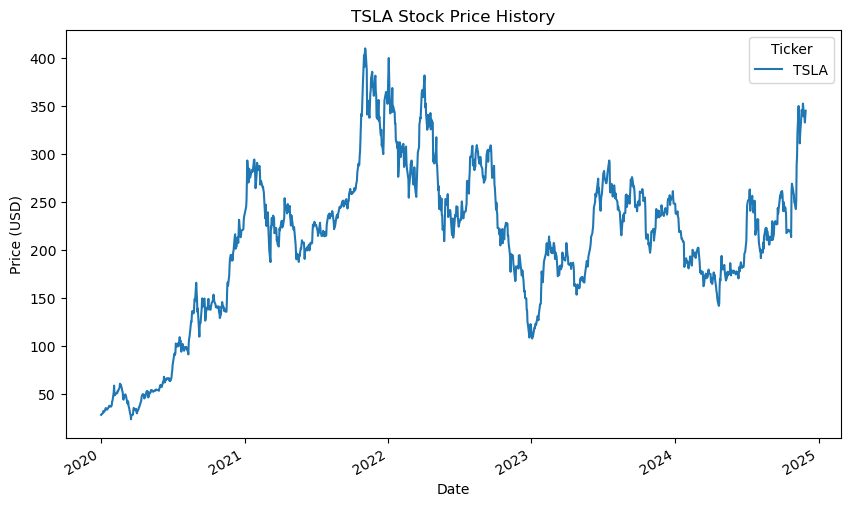

In [43]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the ticker symbol
ticker = "TSLA"

# Fetch stock data
stock_data = yf.download(ticker, start="2020-01-01", end="2024-12-01")

# Check if 'Adj Close' column exists
if 'Adj Close' in stock_data:
    # Plot the stock price history
    stock_data['Adj Close'].plot(title=f"{ticker} Stock Price History", figsize=(10, 6))
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.savefig("tesla_stock_price_history.png")
    print("\nStock price history chart ")
else:
    print("Adjusted Close column not found in stock_data.")


[*********************100%***********************]  1 of 1 completed


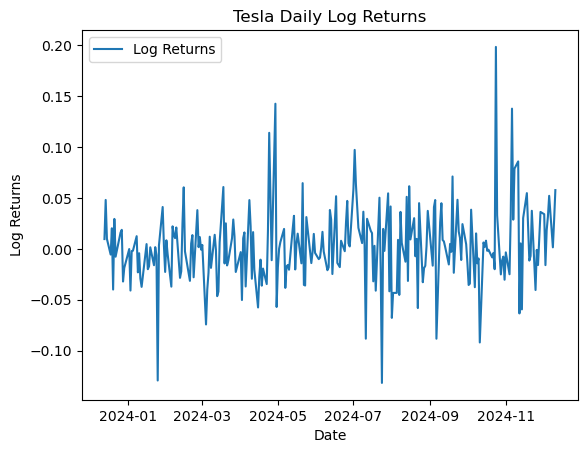

In [44]:
import matplotlib.pyplot as plt

tesla_data = yf.download("TSLA", period="1y")
tesla_data["Log Returns"] = np.log(tesla_data["Close"] / tesla_data["Close"].shift(1))
plt.plot(tesla_data["Log Returns"], label="Log Returns")
plt.title("Tesla Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.show()

### 3. Binomial Tree Option Pricing

In [49]:
import math
import numpy as np

# Parameters
S0 = 100  # Initial stock price
K = 100  # Strike price
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1  # Time to maturity in years
N = 3  # Number of steps

dt = T / N  # Time step
discount = math.exp(-r * dt)  # Discount factor

# Step 1: Calculate u, d, and p
u = math.exp(sigma * math.sqrt(dt))  # Up factor
d = 1 / u  # Down factor
p = (math.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

print(f"u (up factor): {u:.4f}")
print(f"d (down factor): {d:.4f}")
print(f"p (risk-neutral probability): {p:.4f}\n")

# Step 2: Build stock price tree
stock_tree = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    for j in range(i + 1):
        stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)

print("Stock price tree:")
print(stock_tree)

# Step 3: Backward induction for American call option
option_tree = np.zeros((N + 1, N + 1))

# Calculate payoff at maturity
for j in range(N + 1):
    option_tree[j, N] = max(0, stock_tree[j, N] - K)

# Step backward through the tree
for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        # Intrinsic value (if exercised early)
        intrinsic_value = max(0, stock_tree[j, i] - K)
        # Value if held (expected discounted value)
        held_value = discount * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
        # American option value is max of early exercise or hold
        option_tree[j, i] = max(intrinsic_value, held_value)

print("\nOption price tree:")
print(option_tree)

# Step 4: Output the option price at the root
option_price = option_tree[0, 0]
print(f"\nAmerican call option price: {option_price:.4f}")


u (up factor): 1.1224
d (down factor): 0.8909
p (risk-neutral probability): 0.5438

Stock price tree:
[[100.         112.24009024 125.97837858 141.39824581]
 [  0.          89.09472523 100.         112.24009024]
 [  0.           0.          79.37870064  89.09472523]
 [  0.           0.           0.          70.72223522]]

Option price tree:
[[11.04387109 17.71388824 27.6312332  41.39824581]
 [ 0.          3.50065379  6.54586268 12.24009024]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]

American call option price: 11.0439


### Comparision

Manual Calculation (b): 
The American call option price at t=0 was calculated as 11.01

Python Implementation (c): 
The American call option price at t=0 was calculated as 11.0439

The results from both manual and Python calculations were nearly identical, with the small difference attributable to rounding errors in manual computations. Python's accuracy and scalability make it the preferred approach for such financial models, especially for higher step counts or complex derivative pricing.


### Conclusion:

The binomial tree method effectively priced the American call option by modeling possible stock price movements and incorporating early exercise opportunities.
Python implementation is more reliable for practical applications due to its precision and ability to handle more complex scenarios with ease.